In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
from IPython.display import clear_output
import lloyds
from poisson_disc import Grid
from labels import project_positions,create_label
from ase import Atoms
from pyqstem import PyQSTEM
from pyqstem.imaging import CTF
from pyqstem.util import atoms_plot
import matplotlib.pyplot as plt
import matplotlib.path as mplPath
from scipy.spatial import Voronoi
from ase.io import write,read
import scipy.spatial
from glob import glob
from temnn.net.dataset import DataSet, DataEntry

In [2]:
def interpolate_smoothly(points, N):
    half = (len(points) + 1) // 2
    F = np.fft.fft(points)
    F = np.hstack((F[:half],[0]*(len(F)*N),F[half:]))
    return np.fft.fft(F)[::-1].real / len(points)

def blob(N=10,M=50):
    points=np.array([np.random.rand(N),np.random.rand(N)]).T
    points=points[scipy.spatial.ConvexHull(points).vertices]
    points=np.array([interpolate_smoothly(p, M) for p in zip(*points)]).T
    return points-np.mean(points,axis=0)

def random_sheet(cell,r):
    
    grid = Grid(r, cell[0], cell[1])
    
    rand = (np.random.uniform(0, cell[0]), np.random.uniform(0, cell[1]))
    positions = grid.poisson(rand)
    
    positions=lloyds.repeat(positions,cell[:2])
    
    vor=Voronoi(positions)
    
    positions=vor.vertices
    
    positions=positions[positions[:,0]<cell[0]]
    positions=positions[positions[:,0]>0]
    positions=positions[positions[:,1]<cell[1]]
    positions=positions[positions[:,1]>0]
    
    positions=lloyds.relax(positions,cell[:2],num_iter=1,bc='periodic')
    
    num_holes=np.random.randint(0,3)
    for i in range(num_holes):
        size=(.4+.6*np.random.rand())*cell[0]
        hole=size*blob()+[np.random.uniform(0, cell[0]), np.random.uniform(0, cell[1])]
        contained = mplPath.Path(hole).contains_points(positions)
        positions = positions[np.where(contained==0)[0]]
    
    positions=np.hstack((positions,np.array([[0]*len(positions)]).T))
    
    atoms=Atoms(['C']*len(positions),positions)

    atoms.set_cell(cell)
    atoms.set_positions(positions)
    atoms.set_pbc(1)
    atoms.wrap()
    atoms.center()
    
    print(len(atoms), len(atoms)/(cell[0]*cell[1]),2/5.24)
    
    return atoms

Sampling: 0.11953125
564 0.30458687146285934 0.38167938931297707


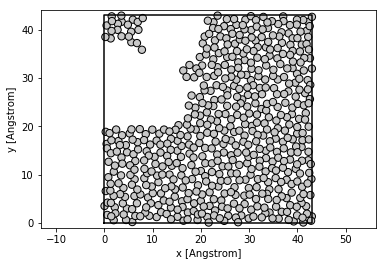

In [3]:
N=360
sampling=24.48/2048*10
print("Sampling:", sampling)
L=sampling*N
cell=(L,L,5)

atoms=random_sheet(cell,1.9)
#atoms=grains_sheet(cell,8)

atoms_plot(atoms)

In [4]:
num_examples=2
#num_examples=len(examples)

dir_name='../data/graphene-random/'
first_number=0
label_size=(N,N)


In [5]:

for i in range(num_examples):
    #atoms=examples[i]
    atoms=random_sheet(cell,1.9)
    
    qstem=PyQSTEM('TEM')
    
    image_size=(int(atoms.get_cell()[0,0]*12),int(atoms.get_cell()[1,1]*12))

    qstem.set_atoms(atoms)
    qstem.build_wave('plane',80,image_size)
    qstem.build_potential(int(atoms.get_cell()[2,2]*2))
    qstem.run()
    wave=qstem.get_wave()
    
    print(wave.sampling)
    
    wave.array=wave.array.astype(np.complex64)
    
    positions=project_positions(atoms,distance=0)/sampling
    classes=[0]*len(positions)
    label=create_label(positions,label_size,6)
    
    np.save('{0}/label/label_{1:04d}.npy'.format(dir_name,first_number+i),label)
    np.savez('{0}/points/points_{1:04d}.npz'.format(dir_name,first_number+i), sites=positions, classes=[0]*len(positions))
    wave.save('{0}/wave/wave_{1:04d}.npz'.format(dir_name,first_number+i))
    write('{0}/model/model_{1:04d}.cfg'.format(dir_name,first_number+i),atoms)
    
    print('iteration',i)
    clear_output(wait=True)

696 0.3758731605286349 0.38167938931297707
(0.083393894135952, 0.083393894135952)
iteration 1


In [6]:
def load(data_dir):
    
    waves=glob(data_dir+"wave/wave_*.npz")
    labels=glob(data_dir+"label/label_*.npy")

    entries=[DataEntry(wave=w,label=l) for w,l in zip(waves,labels)]
    
    return DataSet(entries)

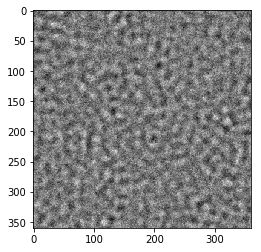

In [7]:
sampling=24.48/2048*10
Cs=np.random.uniform(-20,20)*10**4
defocus=np.random.uniform(-200,200)
focal_spread=np.random.uniform(25,50)
aberrations={'a22':np.random.uniform(0,50),'phi22':np.random.rand()*2*np.pi,'a40':np.random.uniform(0,60)*10**6}
dose=10**np.random.uniform(4,6)
mtf_param=[1,np.random.uniform(0,.1),np.random.uniform(0.4,.6),np.random.uniform(2,3)]
blur=np.random.uniform(0,2)


data = load(dir_name)
entry=data.next_batch(1)[0]

entry.reset()
entry.load()
ctf=CTF(defocus=defocus,Cs=Cs,focal_spread=focal_spread,aberrations=aberrations)
entry.create_image(ctf,sampling,blur,dose,mtf_param)

#entry.crop(crop)

image,label=entry.as_tensors()


plt.imshow(image[0,:,:,0],cmap='gray')
